In [8]:
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, accuracy_score  
from sklearn.linear_model import LogisticRegression
from scipy.io import loadmat
import itertools
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
np.set_printoptions(threshold=np.nan)

pdata = pd.read_csv("../Data/preprocessed_final.csv")
pdata['Conditie'] = pdata['Conditie'].map({'norm': 0,  'bril': 1})

In [9]:
#Splits data into training and validation according to specified ratio
def validation_split(data, ratio):
    sidlist = data['SubjectID'].unique()
    gdata = [data[data['SubjectID']==sid] for sid in sidlist]
    np.random.shuffle(gdata)
    N = len(gdata)
    training = gdata[:int(ratio*N)]
    validation = gdata[(int(ratio*N)):]
    return training,validation

#Converts the arrays in a list to one flattend dataframe
def flatten(data, variable_list):
    return pd.DataFrame(np.vstack(data), columns=variable_list)

#Splits the data to create X_train, y_train, X_test and y_test for the plots
def get_split_data(originaldata, variable_list, ratio):
    data = originaldata[variable_list]
    training,validation = validation_split(data, 0.7)
    training = flatten(training, variable_list)
    validation = flatten(validation, variable_list)

    X_train = training.drop(['Conditie', 'SubjectID'], axis=1)
    y_train = training['Conditie']
    X_train = X_train.astype(float)
    y_train = y_train.astype(int)
    
    X_test = validation.drop(['Conditie', 'SubjectID'], axis=1)
    y_test = validation['Conditie']
    X_test = X_test.astype(float)
    y_test = y_test.astype(int)
    return X_train, X_test, y_train, y_test

collist =  ['SubjectID', 'Conditie', 'mean_StepLength', 'GaitTime', 'mad_SegmentData']
X_train, X_test, y_train, y_test = get_split_data(pdata, collist , 0.7)


X_train = np.array(X_train, dtype=float)
y_train = np.array(y_train, dtype=int)

X_test = np.array(X_test, dtype=float)
y_test = np.array(y_test, dtype=int)


In [10]:
#Apply standardization
scaler = StandardScaler()

scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

#Apply dimensionality reduction
pca = PCA(n_components=2)
pca.fit(X_train)

X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

#Use naive Bayes classifier
gnb = GaussianNB()
gnb.fit(X_train, y_train)

y_pred = gnb.predict(X_test)

print(accuracy_score(y_test, y_pred))

0.8191489361702128


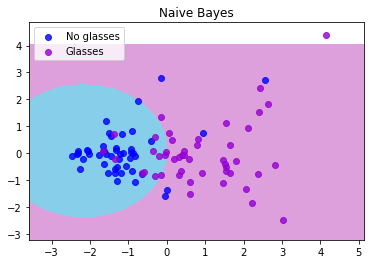

In [11]:
cmap_background = ListedColormap(['skyblue', 'plum'])

#Plot the decision boundary
h = .02
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = gnb.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_background)

#Plot the test points
colors = ['blue', 'darkviolet']
for label in np.unique(y_test):
    indices = np.where(y_test == label)
    plt.scatter(X_test[indices, 0], X_test[indices, 1], c=colors[label], alpha=0.8, 
                label=' {}'.format(label))

#Plot the graph    
labels = ['No glasses', 'Glasses']
plt.legend(labels)
plt.title('Naive Bayes')
# plt.savefig('Naive_Bayes')
plt.show()

In [6]:
#Code that loops thourgh the data 100 times and calculates the accuracy for every loop and returns the mean
def make_decisions(originaldata, variable_list):
    data = originaldata[variable_list]
    training,validation = validation_split(data, 0.7)
    training = flatten(training, variable_list)
    validation = flatten(validation, variable_list)

    X_train = training.drop(['Conditie', 'SubjectID'], axis=1)
    y_train = training['Conditie']
    X_train = X_train.astype(float)
    y_train = y_train.astype(int)
    
    X_test = validation.drop(['Conditie', 'SubjectID'], axis=1)
    y_test = validation['Conditie']
    X_test = X_test.astype(float)
    y_test = y_test.astype(int)
    
    #Standardize the x components
    scaler = StandardScaler()

    scaler.fit(X_train)

    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    #Apply dimensionality reduction
    pca = PCA(n_components=2)
    pca.fit(X_train)

    X_train = pca.transform(X_train)
    X_test = pca.transform(X_test)

    #Fit the classifier
    gnb = GaussianNB()
    gnb.fit(X_train, y_train)

    y_pred = gnb.predict(X_test)

    return accuracy_score(y_test, y_pred) *100



make_decisions(pdata, collist)

86.17021276595744

In [7]:
#Code that prints the accuracy of varies variable combinations
print('mad_SegmentData, mean_StepLength:', round(np.mean([make_decisions(pdata, ['SubjectID', 'Conditie','mean_StepLength', 'mad_SegmentData']) for i in range(100)]), 2),'%.')
print('mean_StepLength, std_SegmentData:', round(np.mean([make_decisions(pdata, ['SubjectID', 'Conditie', 'mean_StepLength', 'std_SegmentData']) for i in range(100)]), 2),'%.')
print('GaitTime, mean_StepLength, mad_SegmentData:', round(np.mean([make_decisions(pdata, ['SubjectID', 'Conditie', 'mean_StepLength', 'GaitTime', 'mad_SegmentData']) for i in range(100)]), 2),'%.')
print('std_SegmentData, GaitVelocity, MovementVelocity, mean_StepLength:', round(np.mean([make_decisions(pdata, ['SubjectID', 'Conditie', 'GaitVelocity', 'MovementVelocity', 'mean_StepLength', 'std_SegmentData']) for i in range(100)]), 2),'%.')
print('GaitTime, GaitVelocity, MovementVelocity, mean_StepLength, std_SegmentData:', round(np.mean([make_decisions(pdata, ['SubjectID', 'Conditie', 'GaitVelocity', 'MovementVelocity', 'mean_StepLength', 'GaitTime', 'std_SegmentData']) for i in range(100)]), 2),'%.')
print('GaitTime, mean_StepLength, Height:', round(np.mean([make_decisions(pdata, ['SubjectID', 'Conditie', 'mean_StepLength', 'GaitTime', 'Height']) for i in range(100)]), 2),'%.')
print('GaitTime, mean_StepLength, Age:', round(np.mean([make_decisions(pdata, ['SubjectID', 'Conditie', 'mean_StepLength', 'GaitTime', 'Age']) for i in range(100)]), 2),'%.')
print('mean_StepLength, Height:', round(np.mean([make_decisions(pdata, ['SubjectID', 'Conditie', 'mean_StepLength', 'Height']) for i in range(100)]), 2),'%.')
print('mean_StepLength, Age:', round(np.mean([make_decisions(pdata, ['SubjectID', 'Conditie', 'mean_StepLength', 'Age']) for i in range(100)]), 2),'%.')
print('GaitTime, Height:', round(np.mean([make_decisions(pdata, ['SubjectID', 'Conditie', 'GaitTime', 'Height']) for i in range(100)]), 2),'%.')
print('std_SegmentData, Height:', round(np.mean([make_decisions(pdata, ['SubjectID', 'Conditie', 'mad_SegmentData', 'Height']) for i in range(100)]), 2),'%.')
print('mad_SegmentData, Age:', round(np.mean([make_decisions(pdata, ['SubjectID', 'Conditie', 'mad_SegmentData', 'Age']) for i in range(100)]), 2),'%.')
print('std_SegmentData, GaitTime, mean_StepLength:', round(np.mean([make_decisions(pdata, ['SubjectID', 'Conditie', 'GaitTime', 'mean_StepLength', 'std_SegmentData']) for i in range(100)]), 2),'%.')




mad_SegmentData, mean_StepLength: 84.51 %.
mean_StepLength, std_SegmentData: 85.01 %.
GaitTime, mean_StepLength, mad_SegmentData: 84.65 %.
std_SegmentData, GaitVelocity, MovementVelocity, mean_StepLength: 84.81 %.
GaitTime, GaitVelocity, MovementVelocity, mean_StepLength, std_SegmentData: 84.99 %.
GaitTime, mean_StepLength, Height: 85.23 %.
GaitTime, mean_StepLength, Age: 85.3 %.
mean_StepLength, Height: 85.31 %.
mean_StepLength, Age: 84.69 %.
GaitTime, Height: 78.95 %.
std_SegmentData, Height: 71.18 %.
mad_SegmentData, Age: 69.96 %.
std_SegmentData, GaitTime, mean_StepLength: 85.26 %.
